### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib import cm
import re
from sklearn import preprocessing, tree, ensemble, linear_model, metrics, model_selection, svm
import xgboost

In [2]:
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')
test = pd.read_csv('assets/west-nile-test.csv')
train = pd.read_csv('assets/west-nile-train.csv')

In [3]:
#dates should be in date-time format for easy wrangling
for i in [spray, weather, test, train]:
    i.Date = pd.to_datetime(i.Date, format='%Y-%m-%d')

### Weather Data - cleaning and wrangling

In [4]:
#many variables are currently objects because they have things like "M" for missing. Must convert.
to_numericize = ['Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
                 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
for col in to_numericize:
    weather[col] = pd.to_numeric(weather[col], errors='coerce')

In [5]:
#for sunrise times and sunset times to be interpreted properly, converting to hours
def twentyfour_hour_to_float(HHMM):
    if HHMM == '-':
        return np.NaN
    else:
        hour = float(HHMM[:2])
        minute = float(HHMM[2:])
        return hour + minute/60
weather.Sunrise = weather.Sunrise.apply(twentyfour_hour_to_float)
weather.Sunset = weather.Sunset.apply(twentyfour_hour_to_float)

#calculate hours in day
weather['hours_in_day'] = weather.Sunset - weather.Sunrise

In [6]:
#Depth, Water1, and SnowFall are all useless variables (all or almost all Nan).
weather.drop(['Depth', 'Water1', 'SnowFall'], axis=1, inplace=True)

In [7]:
#functions to combine data from Station 1 and Station 2, where applicable
def avg_wind_direction(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    elif np.abs(S1-S2) > 18:
        if S1<S2:
            S1+=36
        else:
            S2+=36
        avg = (S1+S2)/2.0
    else:
        avg = (S1+S2)/2.0
    if avg >=36:
        avg-=36
    return avg
def combine_conditions(S1, S2):
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " " and S2 != " ":
        return S2
    elif S1 != " " and S2 == " ":
        return S1
    else:
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))
def avg_col(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    else: 
        avg=(S1+S2)/2.0
    return avg

In [8]:
combined_weather = pd.DataFrame()

s1 = weather[weather.Station==1]
s2 = weather[weather.Station==1]

#columns that only have data for Station 1 or the data are the same.
for col in ['Date', 'Depart', 'Sunrise', 'Sunset', 'hours_in_day']:
    combined_weather[col] = s1[col].values

#application of averaging function
for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed']:
    combined_weather[col] = [avg_col(a, b) for a, b in zip(s1[col].values, s2[col].values)]

#application of unique functions
combined_weather['ResultDir'] = [avg_wind_direction(a, b) for a, b in zip(s1.ResultDir.values, s2.ResultDir.values)]
combined_weather['CodeSum'] = [combine_conditions(a, b) for a, b in zip(s1.CodeSum.values, s2.CodeSum.values)]

#PrecipTotal for each station is too different -- keeping both
combined_weather['PrecipTotal_station1'] = weather.PrecipTotal[weather.Station==1].values
combined_weather['PrecipTotal_station2'] = weather.PrecipTotal[weather.Station==2].values

In [9]:
#Unable to accurately impute for PrecipTotals and too much missing, so starting by dropping those columns
combined_weather.drop(['PrecipTotal_station1', 'PrecipTotal_station2'], axis=1, inplace=True)

In [10]:
# CHANGES MADE TO THIS CELL

#impute missing data for.
subset = combined_weather.columns.drop(['WetBulb', 'Date', 'CodeSum'])

# Create a mask for rows where 'WetBulb' is null but other necessary data is not missing
mask = combined_weather['WetBulb'].isnull() & combined_weather[subset].notna().all(axis=1)
df_train = combined_weather.dropna(subset=['WetBulb'] + list(subset))

X = df_train.drop(['Date', 'WetBulb', 'CodeSum'], axis=1)
y = df_train['WetBulb']

# Train the RandomForestRegressor
dt_WetBulb = ensemble.RandomForestRegressor(n_estimators=100)
dt_WetBulb.fit(X, y)

# Filter the DataFrame for prediction using the defined mask
df_predict = combined_weather.loc[mask, subset]
predicted_WetBulb = dt_WetBulb.predict(df_predict)

combined_weather.loc[mask, 'WetBulb'] = predicted_WetBulb

#StnPressure
X = combined_weather.dropna().drop(['Date', 'StnPressure', 'CodeSum'], axis=1)
y = combined_weather.dropna(subset=subset)['StnPressure']

xb_StnPressure = xgboost.XGBRegressor()
xb_StnPressure.fit(X, y)

predicted_StnPressure = xb_StnPressure.predict(combined_weather.drop(['Date', 'StnPressure', 'CodeSum'], axis=1)[combined_weather.StnPressure.isnull()])

combined_weather.StnPressure[combined_weather.StnPressure.isnull()] = predicted_StnPressure

C:\Users\Leon\AppData\Local\Temp\ipykernel_8628\845995731.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_weather.StnPressure[combined_weather.StnPressure.isnull()] = predicted_StnPressure


In [11]:
combined_weather = combined_weather.drop(columns=['WetBulb', 'SeaLevel'])
print(combined_weather.isnull().sum())

Date            0
Depart          0
Sunrise         0
Sunset          0
hours_in_day    0
Tmax            0
Tmin            0
Tavg            0
DewPoint        0
Heat            0
Cool            0
StnPressure     0
ResultSpeed     0
AvgSpeed        0
ResultDir       0
CodeSum         0
dtype: int64


In [12]:
combined_weather

,Date,Depart,Sunrise,Sunset,hours_in_day,Tmax,Tmin,Tavg,DewPoint,Heat,Cool,StnPressure,ResultSpeed,AvgSpeed,ResultDir,CodeSum
0,2007-05-01,14.0,4.800000,18.816667,14.016667,83.0,50.0,67.0,51.0,0.0,2.0,29.10,1.7,9.2,27.0,
1,2007-05-02,-3.0,4.783333,18.833333,14.050000,59.0,42.0,51.0,42.0,14.0,0.0,29.38,13.0,13.4,4.0,[BR]
2,2007-05-03,2.0,4.766667,18.850000,14.083333,66.0,46.0,56.0,40.0,9.0,0.0,29.39,11.7,11.9,7.0,
3,2007-05-04,4.0,4.733333,18.866667,14.133333,66.0,49.0,58.0,41.0,7.0,0.0,29.31,10.4,10.8,8.0,[RA]
4,2007-05-05,5.0,4.716667,18.883333,14.166667,66.0,53.0,60.0,38.0,5.0,0.0,29.40,11.7,12.0,7.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,16.0,6.300000,16.883333,10.583333,77.0,51.0,64.0,51.0,1.0,0.0,28.92,12.0,12.9,19.0,
1468,2014-10-28,10.0,6.316667,16.850000,10.533333,68.0,45.0,57.0,38.0,8.0,0.0,29.15,14.8,15.6,26.0,
1469,2014-10-29,-4.0,6.333333,16.833333,10.500000,49.0,36.0,43.0,32.0,22.0,0.0,29.36,9.5,9.9,29.0,
1470,2014-10-30,-4.0,6.366667,16.816667,10.450000,51.0,32.0,42.0,34.0,23.0,0.0,29.34,5.1,5.5,24.0,


### Train/Test Data - cleaning and wrangling

In [13]:
#pull out zip codes from address
def find_zip(address):
    if re.search('(?<=IL )[0-9]*', address):
        return re.search('(?<=IL )[0-9]*', address).group(0)
train['zip_code'] = train.Address.apply(find_zip)

In [14]:
# Address, Street, and AddressNumberAndStreet give essentially the same information as Trap, so they can be deleted
train.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

In [15]:
#impute missing zips
X = train.dropna()[['Latitude', 'Longitude']]
y = train.dropna()['zip_code']

dtree_forzip = tree.DecisionTreeClassifier()
dtree_forzip.fit(X, y)
predicted_zip = dtree_forzip.predict(train[['Latitude', 'Longitude']][train.zip_code.isnull()])

train.zip_code[train.zip_code.isnull()] = predicted_zip

C:\Users\Leon\AppData\Local\Temp\ipykernel_8628\549682876.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.zip_code[train.zip_code.isnull()] = predicted_zip


In [16]:
# create columns for day of year, month, day of week:
train['day_of_year'] = train.Date.dt.dayofyear
train['month'] = train.Date.dt.month
train['day_of week'] = train.Date.dt.dayofweek
train['year'] = train.Date.dt.year

In [17]:
#repeat all with test data
test['zip_code'] = test.Address.apply(find_zip)
test.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

predicted_zip = dtree_forzip.predict(test[['Latitude', 'Longitude']][test.zip_code.isnull()])

test.zip_code[test.zip_code.isnull()] = predicted_zip
test['day_of_year'] = test.Date.dt.dayofyear
test['month'] = test.Date.dt.month
test['day_of week'] = test.Date.dt.dayofweek
test['year'] = test.Date.dt.year

C:\Users\Leon\AppData\Local\Temp\ipykernel_8628\3147019951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.zip_code[test.zip_code.isnull()] = predicted_zip


In [18]:
# CHANGES MADE TO THIS CELL

# putting various weights to the traps
num_by_trap = train[['Trap', 'NumMosquitos', 'WnvPresent']].groupby('Trap').agg('sum')

# Calculate percentages
num_by_trap['trap_percent_of_all_mosquitos'] = num_by_trap['NumMosquitos'] / num_by_trap['NumMosquitos'].sum()
num_by_trap['trap_percent_with_wnv'] = num_by_trap['WnvPresent'] / num_by_trap['NumMosquitos']

num_by_trap['trap_percent_of_all_mosquitos'] = num_by_trap['NumMosquitos'] / num_by_trap['NumMosquitos'].sum()
num_by_trap['trap_percent_with_wnv'] = num_by_trap['WnvPresent'] / num_by_trap['NumMosquitos']
num_by_trap.reset_index(inplace=True)  # This line is crucial if 'Trap' is set as the index

map_mosq_weight = {t: v for t, v in zip(num_by_trap['Trap'].values, num_by_trap['trap_percent_of_all_mosquitos'].values)}
map_wnv_weight = {t: v for t, v in zip(num_by_trap['Trap'].values, num_by_trap['trap_percent_with_wnv'].values)}

map_wnv_weight2 = {}
for trap in set(train.Trap):
    map_wnv_weight2[trap] = sum(train.WnvPresent[train.Trap==trap]/sum(train.Trap==trap))
map_wnv_weight2

train['trap_percent_of_all_mosquitos'] = train.Trap.map(map_mosq_weight)
train['trap_percent_with_wnv'] = train.Trap.map(map_wnv_weight)
train['trap_percent_with_wnv2'] = train.Trap.map(map_wnv_weight2)

In [19]:
# Repeat on test data
test['trap_percent_of_all_mosquitos'] = test.Trap.map(map_mosq_weight).fillna(0)
test['trap_percent_with_wnv'] = test.Trap.map(map_wnv_weight).fillna(0)
test['trap_percent_with_wnv2'] = test.Trap.map(map_wnv_weight2).fillna(0)

### Merge

In [20]:
train_w = pd.merge(train, combined_weather, how='left', on='Date')
test_w = pd.merge(test, combined_weather, how='left', on='Date')

### Preprocessing

In [21]:
# Have to pre-process label-encoder on test set because test set has more traps and species.
le_trap = preprocessing.LabelEncoder()
test_w['Trap_num'] = le_trap.fit_transform(test_w.Trap)

# le_species = preprocessing.LabelEncoder()
# test_w['Species_num'] = le_species.fit_transform(test_w.Species)

le_zip = preprocessing.LabelEncoder()
test_w['zip_code_num'] = le_zip.fit_transform(test_w.zip_code)

In [22]:
#repeat with Train
train_w['Trap_num'] = le_trap.transform(train_w.Trap)

# train_w['Species_num'] = le_species.transform(train_w.Species)

train_w['zip_code_num'] = le_zip.transform(train_w.zip_code)

In [23]:
# MultiLabelBinarizer on Codesum
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(test_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

test_w = pd.concat([test_w, mlb_df], axis=1)

In [24]:
# repeat with test
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(train_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

train_w = pd.concat([train_w, mlb_df], axis=1)

## Model Selection

In [25]:
X = train_w.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code'.split(' '), axis=1)
y = train_w.WnvPresent

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

In [27]:
#Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predict = dtree.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.6757883217202498

In [28]:
#Random Forrest
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100)
clf.fit(X_train, y_train)
predict = clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.7867665178406844

In [29]:
#AdaBoost
ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

predict = ada.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.8320798576548363

In [30]:
#XGBoost
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

predict = xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.8224255724561332

In [31]:
#Extra Trees
et = tree.ExtraTreeClassifier()
et.fit(X_train, y_train)
predict = dtree.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.6757883217202498

In [32]:
pd.DataFrame(xgb.feature_importances_, index=X.columns).sort_values(by=0, ascending=False)

,0
day_of_year,0.141065
trap_percent_with_wnv2,0.084284
year,0.080220
TSRA,0.052509
BR,0.050791
Tmin,0.039551
Depart,0.037044
DewPoint,0.036819
Tavg,0.036704
Longitude,0.032366


In [33]:
# CHANGES MADE TO THIS CELL

#Cross-validated scores
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
for model, name in zip([clf, ada, xgb, et], ['clf', 'ada', 'xgb', 'et']):
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print (name, score.mean(), '+/-', score.std())

clf 0.786157676785502 +/- 0.024009468155214517
ada 0.8468873978768505 +/- 0.010987573172588406
xgb 0.8244705227578155 +/- 0.014233562904033785
et 0.6735809463634677 +/- 0.022456316528135224


In [34]:
# CHANGES MADE TO THIS CELL

#Grid-Search to find best parameters
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = model_selection.GridSearchCV(xgboost.XGBClassifier(), param_grid={
        'max_depth':[3,4,5,6, 7],
        'learning_rate':[.04, .06, .08, .1, .12, .14, .16],
    },scoring='roc_auc', cv=cv)
xg_best.fit(X, y).best_params_

# cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = xgboost.XGBRegressor(learning_rate=0.14, max_depth=3)
score = model_selection.cross_val_score(xg_best, X, y, cv=cv, scoring='roc_auc')
print ('score:',score.mean(),"+/-",score.std())

score: 0.8394098175615001 +/- 0.012261755663130423


Didn't perform any better, so we will keep with the simple model. 

In [35]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
predictions = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv)
metrics.roc_auc_score(y, predict[:,1])

0.8187153442761028

AUC: 0.827105641448223


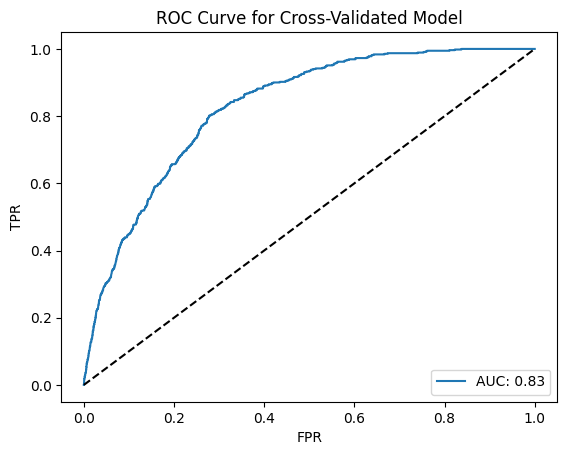

In [36]:
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
y_score = predict[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
print ('AUC:', metrics.auc(fpr, tpr))

plt.plot(fpr, tpr, label='AUC: {:.2}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Cross-Validated Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')

## Threshold Manipulation
Because the threshold must be set very low to pick up on a significant number of traps with west nile virus, I have set certain True Positive Rate thresholds to explore further.

In [37]:
# thresholds for TPR of 80%, 85%, 90%, 95%, and 100%
thresh = [[th for t, f, th in zip(tpr, fpr, thresholds) if t >= i][0] for i in [.8, .85, .9, .95, 1]]

In [38]:
# CHANGES MADE TO THIS CELL

# Print classification reports for each threshold corresponding to the TPRs above.
for i in thresh:
    predictions = [1 if p >= i else 0 for p in y_score]
    print ('threshold:', i)
    print (metrics.classification_report(y, predictions))
    print ('')

threshold: 0.010491992
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      9955
           1       0.14      0.80      0.23       551

    accuracy                           0.73     10506
   macro avg       0.56      0.76      0.53     10506
weighted avg       0.94      0.73      0.80     10506


threshold: 0.0060308636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      9955
           1       0.12      0.85      0.21       551

    accuracy                           0.67     10506
   macro avg       0.55      0.75      0.50     10506
weighted avg       0.94      0.67      0.76     10506


threshold: 0.0028341312
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      9955
           1       0.11      0.90      0.19       551

    accuracy                           0.60     10506
   macro avg       0.55      0.74      0.46     10506
w

In [39]:
# CHANGES MADE TO THIS CELL

# Print confusion matrix for each threshold corresponding to the TPRs above.
for i in thresh:
    predictions = [1 if p >= i else 0 for p in y_score]
    print ('threshold:', i)
    print (metrics.confusion_matrix(y, predictions))
    print ('')

threshold: 0.010491992
[[7190 2765]
 [ 110  441]]

threshold: 0.0060308636
[[6537 3418]
 [  82  469]]

threshold: 0.0028341312
[[5773 4182]
 [  55  496]]

threshold: 0.0007743273
[[4594 5361]
 [  27  524]]

threshold: 3.795359e-05
[[1618 8337]
 [   0  551]]



In [40]:
# CHANGES MADE TO THIS CELL

# Print average yearly savings associated with each threshold, based on an assumed $500 per test
for i in thresh:
    p = [1 if p >= i else 0 for p in y_score]
    print ((metrics.confusion_matrix(y, p)[0,0] + metrics.confusion_matrix(y, p)[1,0])*500/4)

912500.0
827375.0
728500.0
577625.0
202250.0


Text(0.5, 1.0, 'Average Yearly Savings at Various Thresholds')

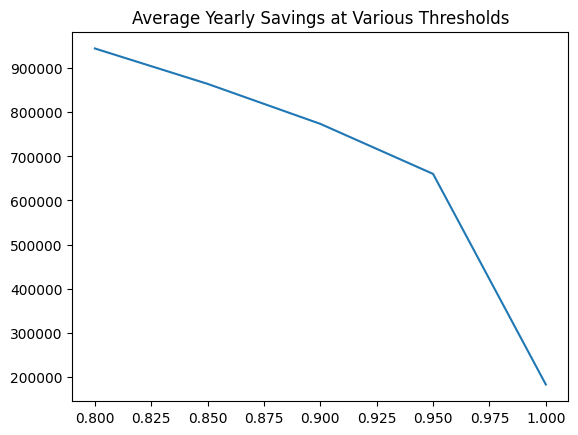

In [41]:
# Graphing savings at each TPR rate
recall = [.8, .85, .9, .95, 1]
savings = [944500, 864250, 773625, 660250, 183000]
plt.plot(recall, savings)
plt.title("Average Yearly Savings at Various Thresholds")

### Kaggle Submission

In [42]:
X = train_w.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code VCTS FG'.split(' '), axis=1)
y = train_w.WnvPresent
X_testset = test_w.drop('Date Trap Species CodeSum zip_code Id BCFG FG+'.split(' '), axis=1)
xgb.fit(X, y)
FINAL = xgb.predict_proba(X_testset)[:,1]

In [43]:
sample = pd.read_csv('assets/sampleSubmission.csv', index_col='Id')

In [44]:
sample.WnvPresent = FINAL

In [45]:
sample.to_csv('assets/testSubmission.csv')